# Bayesian Networks Analysis

`Author: José Luis Maldonado Álvarez`

In [71]:
suppressWarnings(
    suppressPackageStartupMessages({
        library(bnlearn)
        library(Rgraphviz)
        library(gRain)
        library(dplyr)
        library(ggplot2)
        library(gridExtra)
        library(grid)
        library(repr)
    })
)

In [72]:
# Load the dataset
df <- read.csv('FINAL_DATASET.csv')

# Select the socioeconomic variables and the outcome variable and convert them to factors
data <- df %>% select(c(starts_with("SE_"), OUT_MACE)) %>% mutate(across(everything(), as.factor))
levels(data$SE_HI) <- c("MED", "HIGH", "LOW") # Recode SE_HI levels for clarity in plots

dim(data) # 16 predictors + 1 outcome variable
str(data)

[1] 2109   16

'data.frame':	2109 obs. of  16 variables:
 $ SE_MS   : Factor w/ 2 levels "1","2": 1 1 2 1 1 1 1 1 1 1 ...
 $ SE_SUP  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_RES  : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 2 1 1 1 ...
 $ SE_STU  : Factor w/ 2 levels "1","2": 2 1 2 1 1 1 1 1 2 1 ...
 $ SE_EX   : Factor w/ 2 levels "0","1": 1 2 1 2 2 2 2 2 2 2 ...
 $ SE_HW   : Factor w/ 2 levels "0","1": 1 2 1 2 1 1 1 1 2 1 ...
 $ SE_PET  : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 1 1 1 2 ...
 $ SE_INT  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_TSI  : Factor w/ 2 levels "0","1": 2 1 1 2 1 1 1 2 2 2 ...
 $ SE_ACTT : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ SE_SH   : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_TEH  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_CCH  : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 2 2 2 2 ...
 $ SE_ENH  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_HI   : Factor w/ 3 levels "MED","HIGH","LO

## Building BN with Hill-Climbing and Tabu algorithms

BIC score of the DAG learned with hill-climbing: -17594.99 
BIC score of the DAG learned with tabu search: -17588.01 


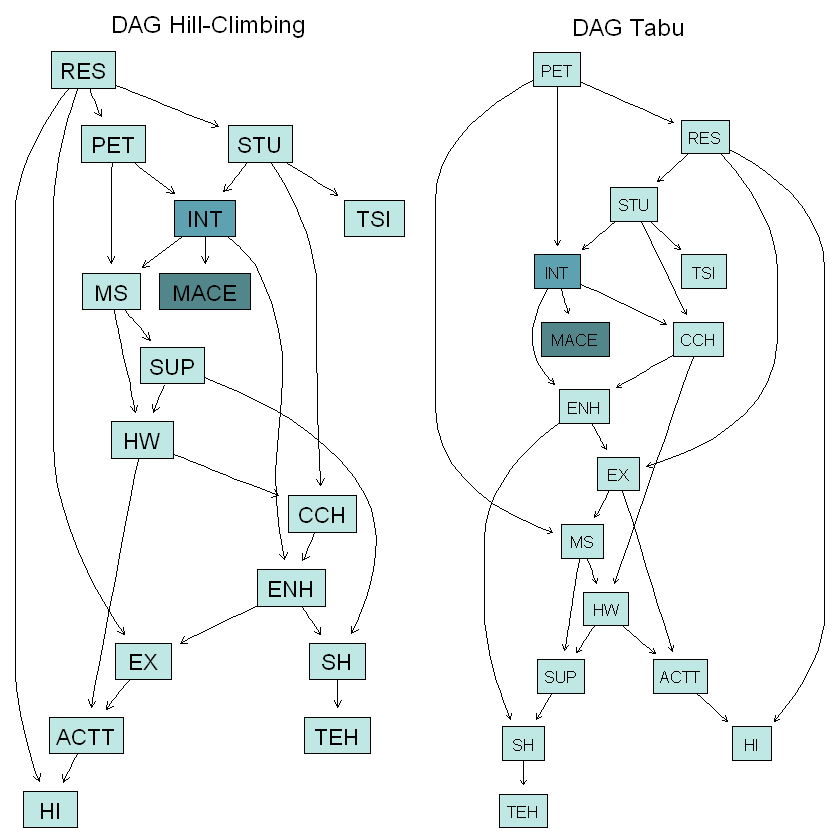

In [73]:
# Learn the DAG using the hill-climbing algorithm
dag_hc <- hc(data, score = "bic")
score_hc <- score(dag_hc, data = data, type = "bic")

# Learn the DAG using the tabu search algorithm
dag_tabu <- tabu(data, score = "bic")
score_tabu <- score(dag_tabu, data = data, type = "bic")

# Compare the scores
cat("BIC score of the DAG learned with hill-climbing:", score_hc, "\n")
cat("BIC score of the DAG learned with tabu search:", score_tabu, "\n")

# Markov blankets
mb_hc <- mb(dag_hc, "OUT_MACE")
mb_tabu <- mb(dag_tabu, "OUT_MACE")

# Function to assign node colors
get_node_colors <- function(dag, mb_nodes) {
    colors <- rep("#BFE8E4", length(nodes(dag)))
    names(colors) <- nodes(dag)
    colors["OUT_MACE"] <- "#53868B"
    colors[mb_nodes] <- "#5EA1B0"
    return(colors)
}

# Function to remove prefixes
remove_prefix <- function(x) sub("^(SE_|OUT_)", "", x)

node_colors_hc <- get_node_colors(dag_hc, mb_hc)
node_colors_tabu <- get_node_colors(dag_tabu, mb_tabu)

# Create label vectors without prefixes
labels_hc <- setNames(remove_prefix(nodes(dag_hc)), nodes(dag_hc))
labels_tabu <- setNames(remove_prefix(nodes(dag_tabu)), nodes(dag_tabu))

par(mfrow = c(1, 2), bg = "white")
g_hc <- graphviz.plot(dag_hc, main = "DAG Hill-Climbing", render = FALSE)
graph::nodeRenderInfo(g_hc)$fill <- node_colors_hc
graph::nodeRenderInfo(g_hc)$label <- labels_hc
Rgraphviz::renderGraph(g_hc)

g_tabu <- graphviz.plot(dag_tabu, main = "DAG Tabu", render = FALSE)
graph::nodeRenderInfo(g_tabu)$fill <- node_colors_tabu
graph::nodeRenderInfo(g_tabu)$label <- labels_tabu
Rgraphviz::renderGraph(g_tabu)

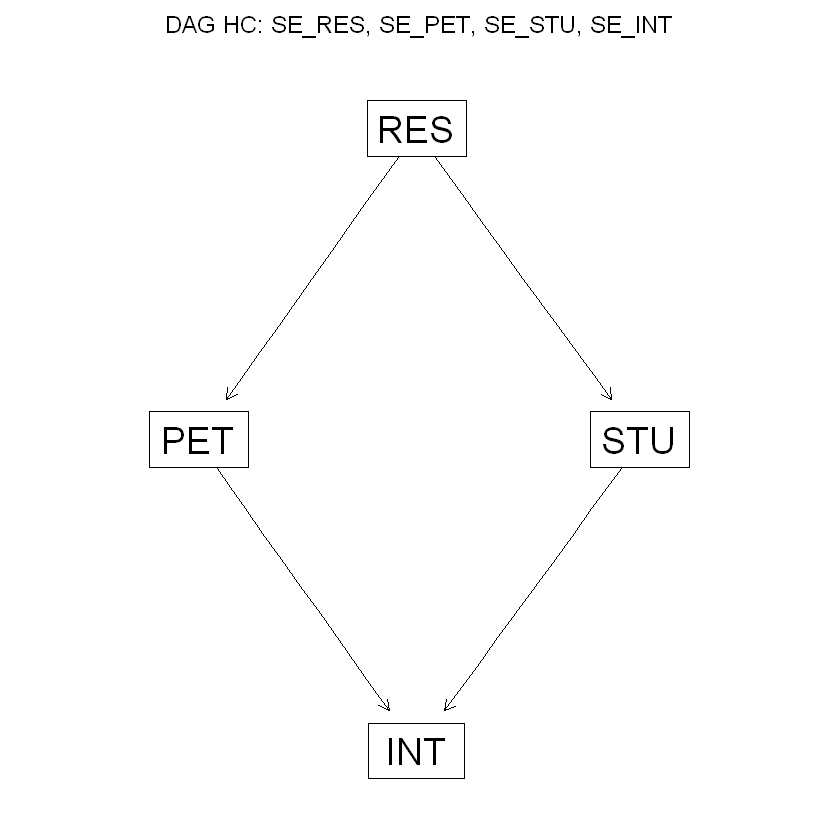

In [74]:
# EXAMPLE DAG FOR MEMORY

# Subset data for selected variables
data_sel <- data %>% select(SE_RES, SE_PET, SE_STU, SE_INT)
# Learn the DAG using hill-climbing for the selected variables
dag_sel <- hc(data_sel, score = "bic")

# Plot the DAG
par(bg = "white")
g_sel <- graphviz.plot(dag_sel, main = "DAG HC: SE_RES, SE_PET, SE_STU, SE_INT", render = FALSE)
labels_sel <- setNames(remove_prefix(nodes(dag_sel)), nodes(dag_sel))
graph::nodeRenderInfo(g_sel)$label <- labels_sel
Rgraphviz::renderGraph(g_sel)

# Fit the Bayesian network to get CPTs
bn_sel <- bn.fit(dag_sel, data = data_sel)

# # Print CPTs for each node
# cat("Conditional Probability Tables for each node:\n")
# for (node in nodes(dag_sel)) {
#     cat("\nNode:", node, "\n")
#     print(bn_sel[[node]])
# }

Hill-Climbing BIC scores (test set):
  Max: -17226.36   Min: -17805.8   Mean: -17547.41 
Tabu Search BIC scores (test set):
  Max: -17226.36   Min: -17804.81   Mean: -17545.06 



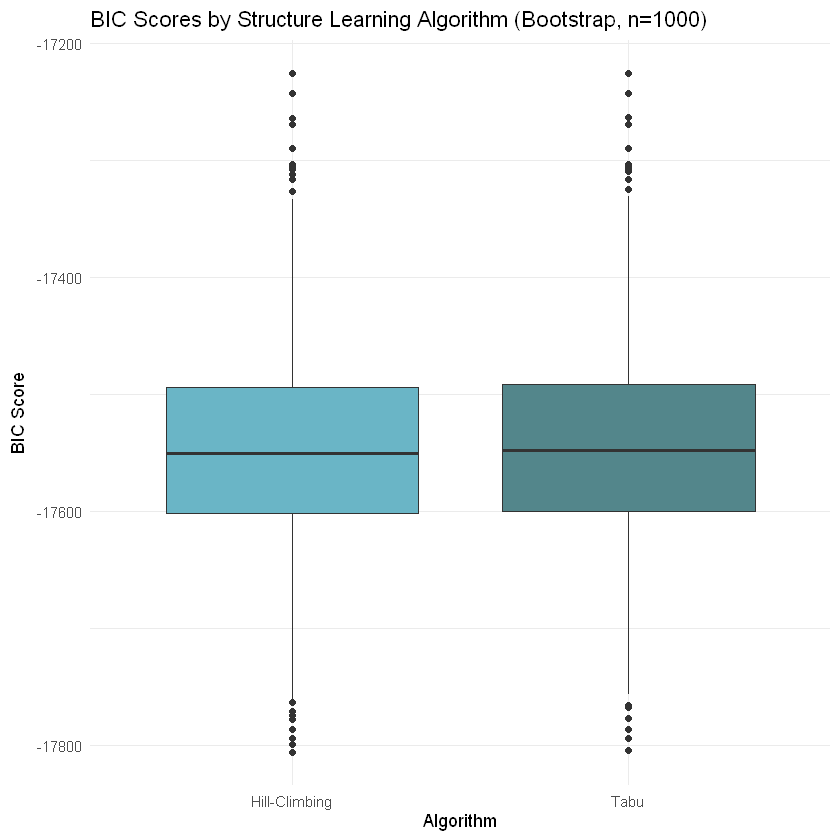

In [75]:
# Compare the BIC scores of the two DAG learning algorithms (Hill-Climbing and Tabu)
set.seed(1)
scores_hc <- numeric(1000)
scores_tabu <- numeric(1000)
for (i in 1:1000) {
    sample <- data[sample(nrow(data), replace = TRUE), ]
    dag_hc_tmp <- hc(sample, score = "bic")
    scores_hc[i] <- score(dag_hc_tmp, data = sample, type = "bic")
    dag_tabu_tmp <- tabu(sample, score = "bic")
    scores_tabu[i] <- score(dag_tabu_tmp, data = sample, type = "bic")
}

cat("Hill-Climbing BIC scores (test set):\n")
cat("  Max:", max(scores_hc),"  Min:", min(scores_hc), "  Mean:", mean(scores_hc), "\n")

cat("Tabu Search BIC scores (test set):\n")
cat("  Max:", max(scores_tabu),"  Min:", min(scores_tabu),"  Mean:", mean(scores_tabu), "\n\n")

# Combine scores into a data frame for plotting
scores_df <- data.frame(
    Score = c(scores_hc, scores_tabu),
    Algorithm = factor(rep(c("Hill-Climbing", "Tabu"), each = 1000))
)

# Plot boxplots of BIC scores for each algorithm
ggplot(scores_df, aes(x = Algorithm, y = Score, fill = Algorithm)) +
    geom_boxplot() +
    labs(title = "BIC Scores by Structure Learning Algorithm (Bootstrap, n=1000)",
         y = "BIC Score", x = "Algorithm") +
    theme_minimal() +
    scale_fill_manual(values = c("Hill-Climbing" = "#6ab5c6", "Tabu" = "#53868B")) +
    theme(legend.position = "none")

In [76]:
# Use bn.cv to compare hc and tabu algorithms
bn.cv(data, 'hc', loss = "pred", loss.args = list(target = "OUT_MACE"))
bn.cv(data, 'tabu', loss = "pred", loss.args = list(target = "OUT_MACE"))


  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Hill-Climbing 
  number of folds:                       10 
  loss function:                         Classification Error 
  training node:                         OUT_MACE 
  expected loss:                         0.1920341 



  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Tabu Search 
  number of folds:                       10 
  loss function:                         Classification Error 
  training node:                         OUT_MACE 
  expected loss:                         0.1920341 


In [77]:
# Calculate the strength of the relationships between nodes for the restricted models
arc_strength_hc <- arc.strength(dag_hc, data = data, criterion = "x2")
arc_strength_tabu <- arc.strength(dag_tabu, data = data, criterion = "x2")

cat("\nStrength of the relationships (Hill-Climbing with restrictions):\n")
print(arc_strength_hc)

cat("\nStrength of the relationships (Tabu with restrictions):\n")
print(arc_strength_tabu)


Strength of the relationships (Hill-Climbing with restrictions):
      from       to     strength
1   SE_STU   SE_INT 4.601578e-42
2    SE_MS    SE_HW 8.297635e-32
3    SE_EX  SE_ACTT 2.363184e-30
4   SE_RES    SE_HI 5.506649e-26
5    SE_MS   SE_SUP 3.441808e-24
6   SE_STU   SE_CCH 6.095607e-20
7   SE_CCH   SE_ENH 6.148273e-11
8   SE_RES   SE_PET 8.557204e-15
9   SE_RES   SE_STU 6.842506e-10
10  SE_PET   SE_INT 1.933824e-09
11  SE_INT OUT_MACE 3.423684e-09
12  SE_ENH    SE_SH 1.706718e-07
13   SE_SH   SE_TEH 4.682568e-16
14  SE_INT   SE_ENH 8.678672e-09
15 SE_ACTT    SE_HI 7.145313e-10
16  SE_ENH    SE_EX 9.394318e-11
17   SE_HW  SE_ACTT 4.483959e-08
18   SE_HW   SE_CCH 7.940739e-08
19  SE_PET    SE_MS 1.019153e-04
20  SE_SUP    SE_HW 7.205815e-05
21  SE_STU   SE_TSI 1.419454e-04
22  SE_RES    SE_EX 7.031386e-05
23  SE_SUP    SE_SH 2.941560e-08
24  SE_INT    SE_MS 3.374530e-04

Strength of the relationships (Tabu with restrictions):
      from       to     strength
1   SE_STU   SE_INT

Bayesian Network fitted with Hill-Climbing DAG:
  Parameters of node OUT_MACE (multinomial distribution)

Conditional probability table:
 
        SE_INT
OUT_MACE         0         1
       0 0.7145833 0.8354819
       1 0.2854167 0.1645181
Number of parameters in the fitted model: 53 

Bayesian Network fitted with Tabu DAG:
  Parameters of node OUT_MACE (multinomial distribution)

Conditional probability table:
 
        SE_INT
OUT_MACE         0         1
       0 0.7145833 0.8354819
       1 0.2854167 0.1645181
Number of parameters in the fitted model: 55 


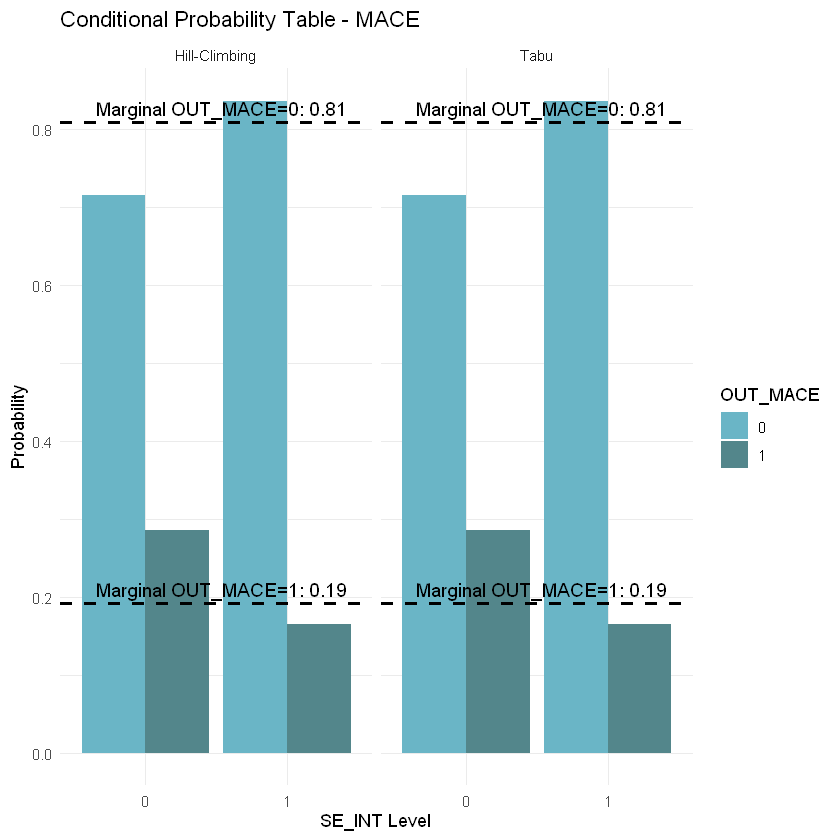

In [78]:
# Fit the Bayesian networks using the learned DAGs
set.seed(1) # For reproducibility

cat("Bayesian Network fitted with Hill-Climbing DAG:")
bn_hc <- bn.fit(dag_hc, data = data)
print(bn_hc$OUT_MACE)
cat("Number of parameters in the fitted model:", suppressWarnings(nparams(bn_hc)), "\n")
df_hc <- as.data.frame(as.table(coef(bn_hc$OUT_MACE)))
df_hc$Method <- "Hill-Climbing"

cat("\nBayesian Network fitted with Tabu DAG:")
bn_tabu <- bn.fit(dag_tabu, data = data)
print(bn_tabu$OUT_MACE)
cat("Number of parameters in the fitted model:", suppressWarnings(nparams(bn_tabu)), "\n")
df_tabu <- as.data.frame(as.table(coef(bn_tabu$OUT_MACE)))
df_tabu$Method <- "Tabu"

# Combine data for both plots
df_combined <- rbind(df_hc, df_tabu)

# Plot both in one using facets
# Calculate marginal probability of OUT_MACE = "1"
marginal_prob <- prop.table(table(data$OUT_MACE))

ggplot(df_combined, aes(x = SE_INT, y = Freq, fill = OUT_MACE)) +
        geom_bar(stat = "identity", position = "dodge") +
        facet_wrap(~Method) +
        scale_fill_manual(values = c("0" = "#6ab5c6", "1" = "#53868B")) +
        labs(title = "Conditional Probability Table - MACE",
                 x = "SE_INT Level", y = "Probability") +
        theme_minimal() +
        geom_hline(yintercept = marginal_prob["1"], linetype = "dashed", color = "black", linewidth = 1) +
        annotate("text", x = Inf, y = marginal_prob["1"], label = sprintf("Marginal OUT_MACE=1: %.2f", marginal_prob["1"]),
                         vjust = -0.5, hjust = 1.1, color = "black", size = 4) +
        geom_hline(yintercept = marginal_prob["0"], linetype = "dashed", color = "black", linewidth = 1) +
        annotate("text", x = Inf, y = marginal_prob["0"], label = sprintf("Marginal OUT_MACE=0: %.2f", marginal_prob["0"]),
                         vjust = -0.5, hjust = 1.1, color = "black", size = 4)
        

In [79]:
# Perform inference using the bnlearn package
cat("\nInference using the bnlearn package with evidence SE_INT = 1:")
print(cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = (SE_INT == "1")))

# Perform inference using the gRain package (exact inference)
bn_hc_grain <- compile(as.grain(bn_hc))
cat("Conditional probability of OUT_MACE given SE_INT = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_INT = 1 and SE_STU = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_STU = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_INT = 1 and SE_PET = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_PET = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_PET = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_PET = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_STU = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_STU = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_PET = 1 and SE_STU = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_PET = "1", SE_STU = "1"))$OUT_MACE)
cat("Conditional probability of OUT_MACE given SE_PET = 1:\n")
print(querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_PET = "1"))$OUT_MACE)


Inference using the bnlearn package with evidence SE_INT = 1:[1] 0.1617858
Conditional probability of OUT_MACE given SE_INT = 1:
OUT_MACE
        0         1 
0.8354819 0.1645181 
Conditional probability of OUT_MACE given SE_INT = 1 and SE_STU = 1:
OUT_MACE
        0         1 
0.8354819 0.1645181 
Conditional probability of OUT_MACE given SE_INT = 1 and SE_PET = 1:
OUT_MACE
        0         1 
0.8354819 0.1645181 
Conditional probability of OUT_MACE given SE_PET = 1:
OUT_MACE
        0         1 
0.8156214 0.1843786 
Conditional probability of OUT_MACE given SE_STU = 1:
OUT_MACE
        0         1 
0.7951222 0.2048778 
Conditional probability of OUT_MACE given SE_PET = 1 and SE_STU = 1:
OUT_MACE
        0         1 
0.8040116 0.1959884 
Conditional probability of OUT_MACE given SE_PET = 1:
OUT_MACE
        0         1 
0.8156214 0.1843786 


Exact conditional probabilities of OUT_MACE = 1:
$`OUT_MACE|SE_INT=1`
        1 
0.1645181 

$`OUT_MACE|SE_STU=1`
        1 
0.2048778 

$`OUT_MACE|SE_PET=1`
        1 
0.1843786 

$`OUT_MACE|SE_INT=1,SE_STU=1`
        1 
0.1645181 

$`OUT_MACE|SE_INT=1,SE_PET=1`
        1 
0.1645181 

$`OUT_MACE|SE_PET=1,SE_STU=1`
        1 
0.1959884 



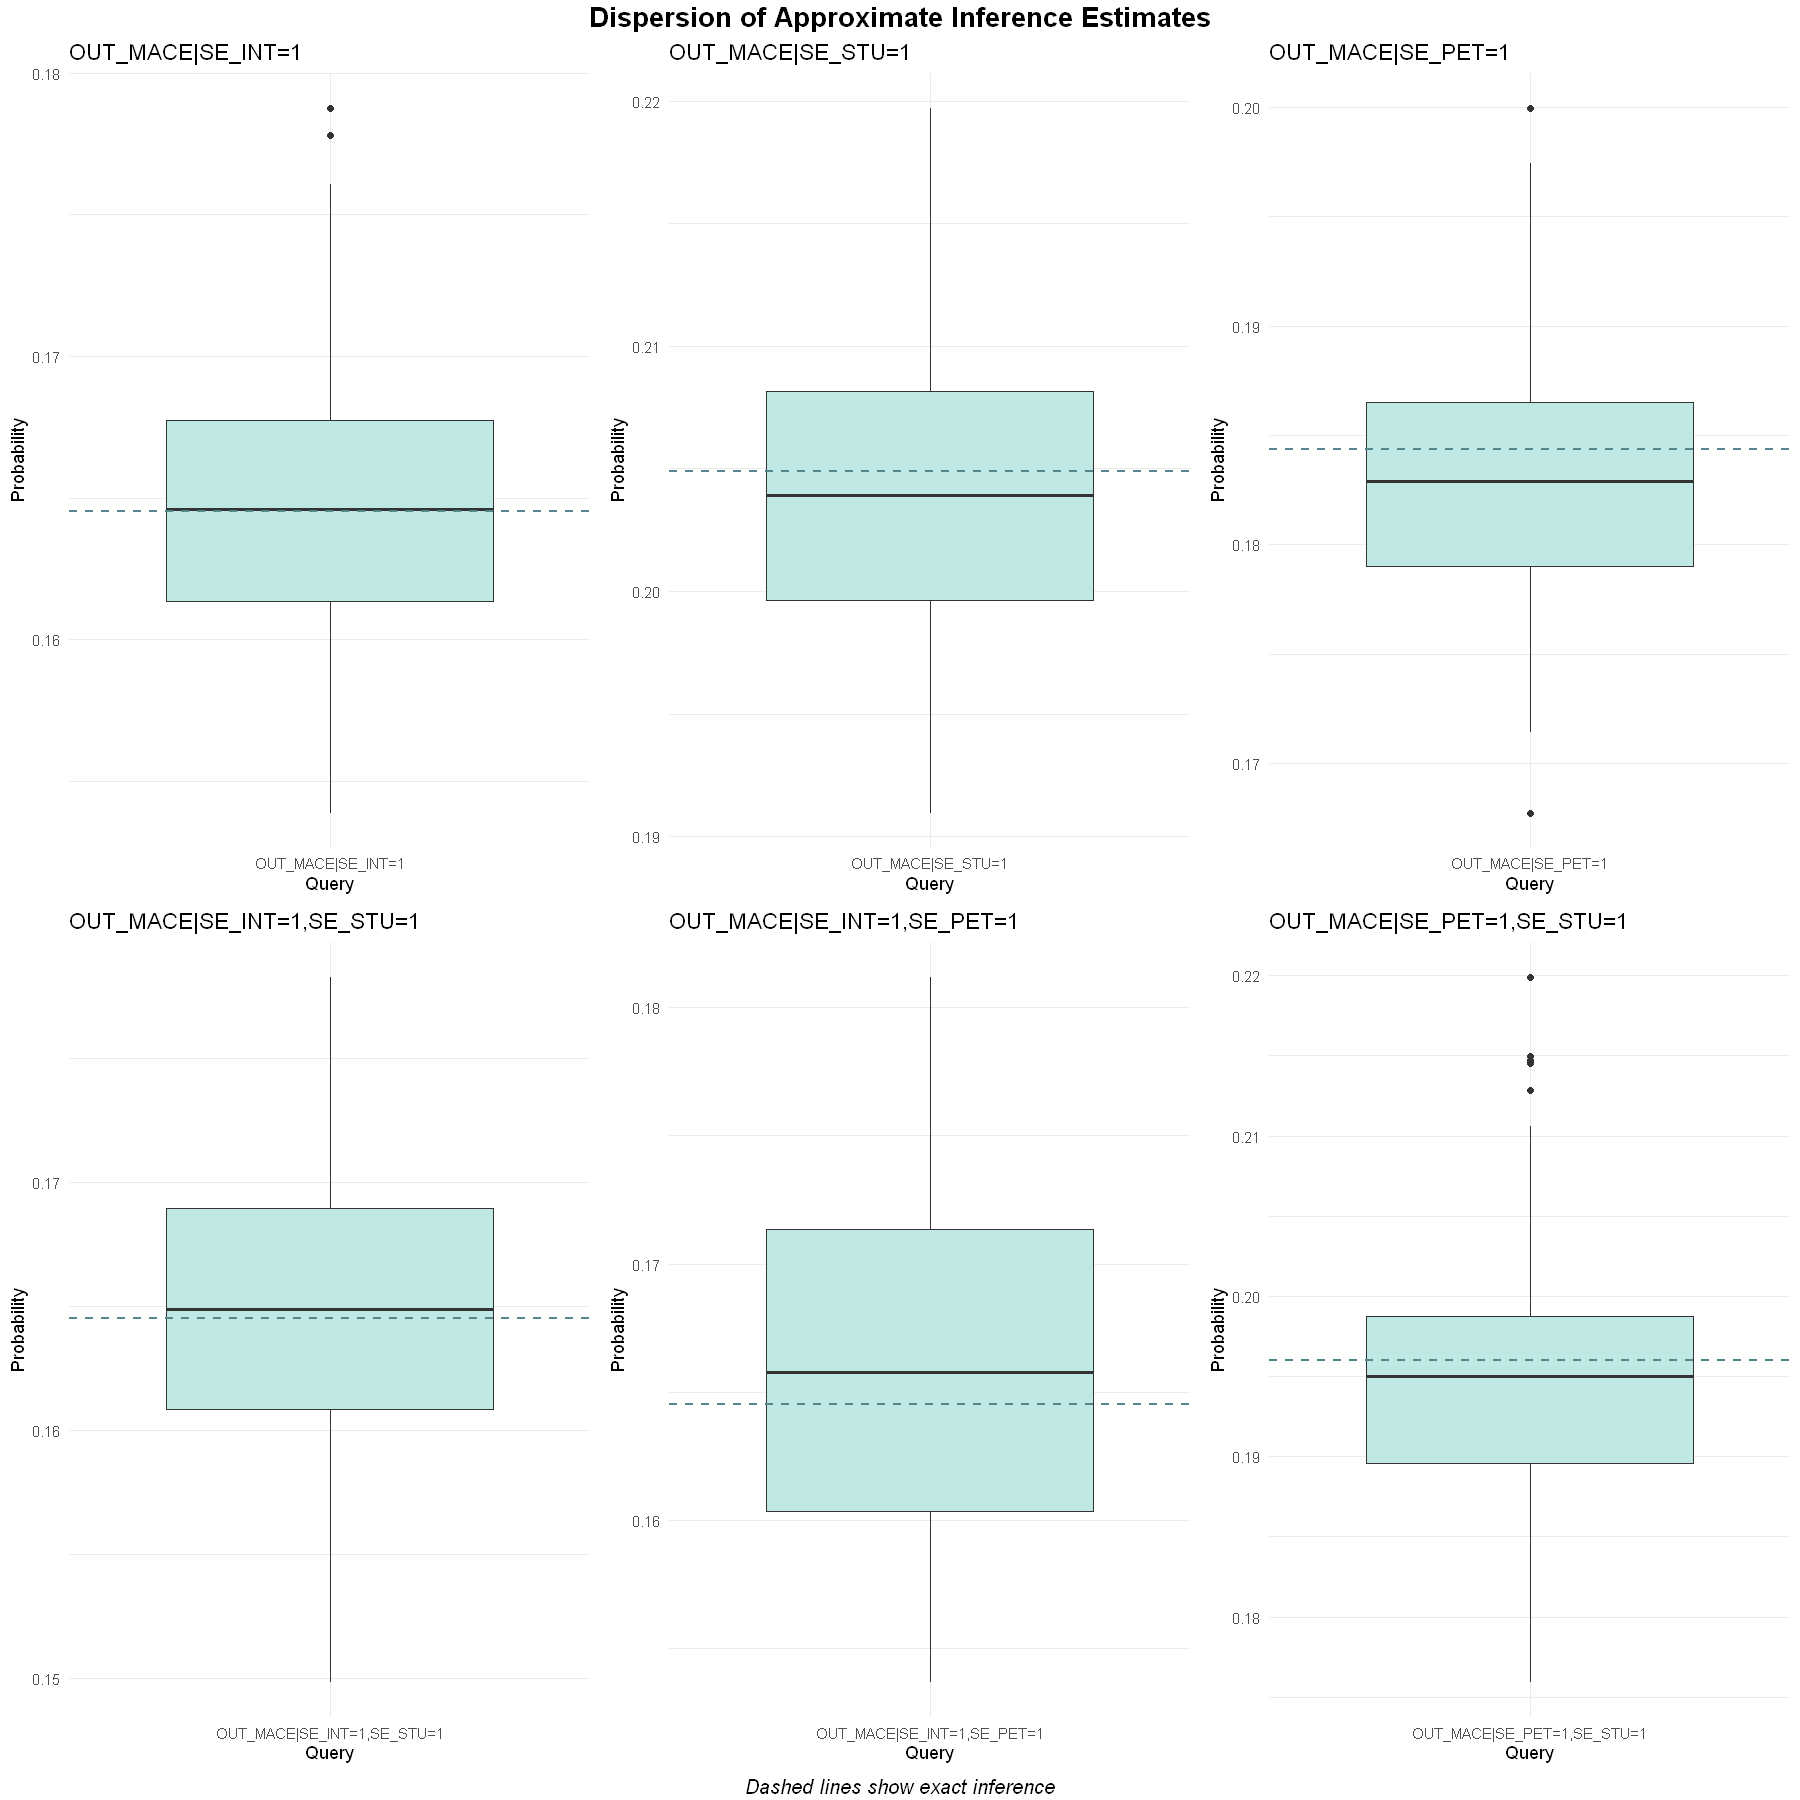

In [80]:
# Exact inference for the Bayesian network using the hill-climbing DAG
bn_hc_grain <- compile(as.grain(bn_hc))

# Store exact probabilities for each query in a named list
exact_probs <- list(
    "OUT_MACE|SE_INT=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_STU=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_STU = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_PET=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_PET = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=1,SE_STU=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_STU = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=1,SE_PET=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_PET = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_PET=1,SE_STU=1" = querygrain(bn_hc_grain, nodes = "OUT_MACE", evidence = list(SE_PET = "1", SE_STU = "1"))$OUT_MACE["1"]
)

# Print all exact probabilities in a compact way
cat("Exact conditional probabilities of OUT_MACE = 1:\n")
print(exact_probs)

# Approximate inference using cpquery
set.seed(0)
approx_outmace_seint1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = (SE_INT == "1")))
approx_outmace_sestu1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = (SE_STU == "1")))
approx_outmace_sepet1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = (SE_PET == "1")))
approx_outmace_seint1_sestu1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = ((SE_INT == "1") & (SE_STU == "1"))))
approx_outmace_seint1_sepet1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = ((SE_INT == "1") & (SE_PET == "1"))))
approx_outmace_sepet1_sestu1 <- replicate(100, cpquery(bn_hc, event = (OUT_MACE == "1"), evidence = ((SE_PET == "1") & (SE_STU == "1"))))

# Combine results into a data frame for visualization
approx_results <- data.frame(
    Variable = rep(c(
        "OUT_MACE|SE_INT=1",
        "OUT_MACE|SE_STU=1",
        "OUT_MACE|SE_PET=1",
        "OUT_MACE|SE_INT=1,SE_STU=1",
        "OUT_MACE|SE_INT=1,SE_PET=1",
        "OUT_MACE|SE_PET=1,SE_STU=1"
    ), each = 100),
    Probability = c(
        approx_outmace_seint1,
        approx_outmace_sestu1,
        approx_outmace_sepet1,
        approx_outmace_seint1_sestu1,
        approx_outmace_seint1_sepet1,
        approx_outmace_sepet1_sestu1
    )
)

options(repr.plot.width = 15, repr.plot.height = 15)

# Create boxplots for each query, add exact inference line
plots <- lapply(unique(approx_results$Variable), function(var) {
    ggplot(subset(approx_results, Variable == var), aes(x = Variable, y = Probability)) +
        geom_boxplot(fill = "#BFE8E4") +
        geom_hline(yintercept = exact_probs[[var]], linetype = "dashed", color = "#53868B", lwd = 0.75) +
        labs(x = "Query", y = "Probability", title = var) +
        theme_minimal()
})

# Arrange plots in a grid with bold and centered title
grid.arrange(
    grobs = plots,
    ncol = 3,
    top = textGrob("Dispersion of Approximate Inference Estimates", gp = gpar(fontsize = 16, fontface = "bold"), just = "center", hjust = 0.5),
    bottom = textGrob("Dashed lines show exact inference", gp = gpar(fontsize = 12, fontface = "italic"))
)

In [81]:
options(repr.plot.width = NULL, repr.plot.height = NULL) # Reset plot dimensions

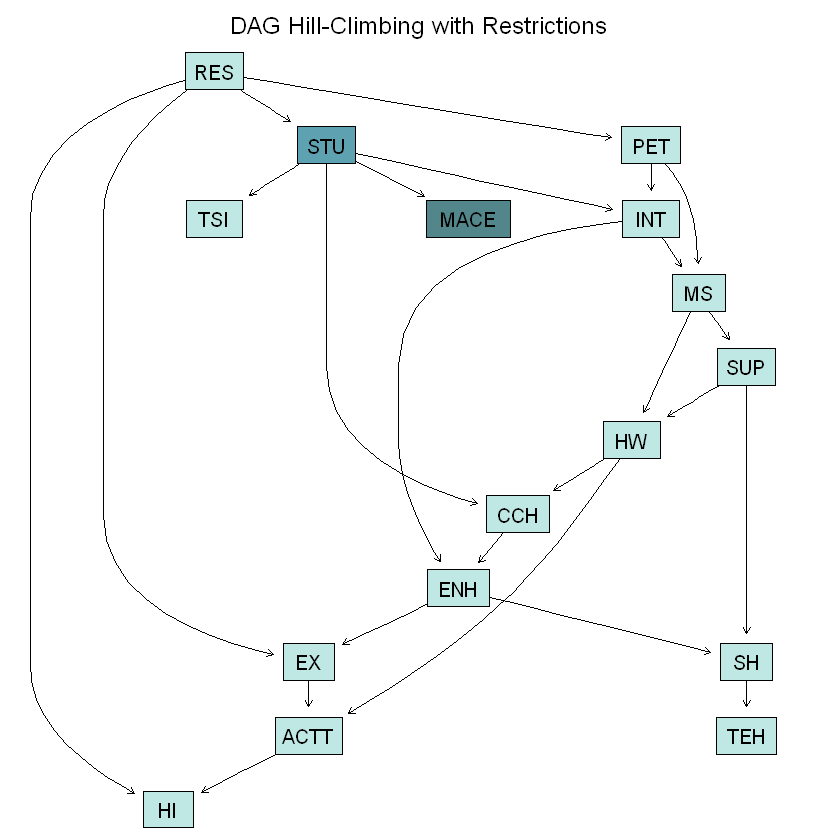

In [82]:
# Learn DAG with restrictions
dag_hc2 <- hc(data, score = "bic", blacklist = matrix(c("SE_INT","OUT_MACE","OUT_MACE","SE_INT"), ncol = 2, byrow = TRUE))
score_hc <- score(dag_hc2, data = data, type = "bic")
mb_hc2 <- mb(dag_hc2, "OUT_MACE")

node_colors_hc <- get_node_colors(dag_hc2, mb_hc2)
labels_hc2 <- setNames(remove_prefix(nodes(dag_hc2)), nodes(dag_hc2))

par(bg = "white")
g_hc2 <- graphviz.plot(dag_hc2, main = "DAG Hill-Climbing with Restrictions", render = FALSE)
graph::nodeRenderInfo(g_hc2)$fill <- node_colors_hc
graph::nodeRenderInfo(g_hc2)$label <- labels_hc2
Rgraphviz::renderGraph(g_hc2)

## Bootstrap BN creation 

In [ ]:
# Function to color the nodes
color_nodes <- function(nodes, mmarkov, target) {
    sapply(nodes, function(node) {
        if (node %in% mmarkov) {
            "#5EA1B0"
        } else if (node == target) {
            "#53868B"
        } else if (startsWith(node, "SE")) {
            "#BFE8E4"
        } else {
            "white"
        }
    })
}

# Function to draw the final DAG and show the strength of the arcs
draw_final_dag <- function(arcs, nodes, mmarkov, target, data, size){
    arcs <- unique(arcs)
    dag <- empty.graph(nodes)
    arcs(dag) <- arcs
    g <- graphviz.plot(dag, render = FALSE)
    attrs <- list(node = list(shape = "ellipse", fontsize = 30, fillcolor = "lightgrey", style = "filled"),
                  edge = list(arrowsize = 1), graph = list(bgcolor = "white"))
    graph::graphRenderInfo(g) <- attrs
    colors <- color_nodes(nodes, mmarkov, target)
    graph::nodeRenderInfo(g)$fill <- colors
    graph::nodeRenderInfo(g)$col <- "black"
    graph::nodeRenderInfo(g)$textCol <- "black"
    # graph::nodeRenderInfo(g)$fontsize <- 20
    clean_labels <- gsub("^(SE_|OUT_)", "", nodes) # Remove "SE_" and "OUT_" prefixes from node labels
    names(clean_labels) <- nodes
    graph::nodeRenderInfo(g)$label <- clean_labels
    variables <- intersect(names(data), nodes)
    data <- data[, variables, drop = FALSE]
    arc_strengths <- suppressWarnings(arc.strength(dag, data = data, criterion = "bic"))
    arc_strengths <- arc_strengths[order(-arc_strengths$strength), ]
    arc_strengths$abs_strength <- abs(as.numeric(sub(".*?(-?\\d+).*", "\\1", as.character(arc_strengths$strength))))
    arc_strengths$width <- cut(arc_strengths$abs_strength, breaks = c(-Inf, 10, 20, 50, 100, 200, Inf), labels = c(1, 2, 3, 4, 5, 6))
    edge_weights <- setNames(as.numeric(arc_strengths$width), paste(arc_strengths$from, arc_strengths$to, sep = "~"))
    edgeRenderInfo(g)$lwd <- edge_weights
    edgeRenderInfo(g)$col <- "black"
    cat("Final arcs ordered by strength:\n")
    print(arc_strengths[, c("from", "to", "strength", "abs_strength", "width")])
    Rgraphviz::renderGraph(g)
}

# Bootstrap funtion for the DAG (using 100 iterations by default)
create_dag_bootstrap <- function(data, target, n_iter = 100, seed = 1){
    set.seed(seed)
    results <- list()
    for (i in 1:n_iter) {
        sample <- data[sample(nrow(data), replace = TRUE), ]
        structure <- hc(sample) # Create the structure of the Bayesian Network using hc
        arcs <- arcs(structure)
        nodes <- nodes(structure)
        mmarkov <- mb(structure, node = target)
        results[[i]] <- list(structure = structure, arcs = arcs, nodes = nodes, mmarkov = mmarkov)
    }
    return(results)
}

# Function to calculate the frequency of each arcs
calculate_arc_frequency <- function(results){
    arcs_list <- lapply(results, function(res) {
        arcs <- res$arcs
        data.frame(from = arcs[, 1], to = arcs[, 2])
    })
    combined_arcs <- do.call(rbind, arcs_list)
    arcs_table <- as.data.frame(table(paste(combined_arcs$from, combined_arcs$to, sep = "~")))
    arcs_table <- arcs_table[order(-arcs_table$Freq), ]
    separated_arcs <- as.data.frame(do.call(rbind, strsplit(as.character(arcs_table$Var1), "~")))
    colnames(separated_arcs) <- c("from", "to")
    arcs_table <- cbind(separated_arcs, arcs_table$Freq)
    colnames(arcs_table) <- c("from", "to", "Freq")
    return(arcs_table)
}

# Function to check if an arc exists in the graph (useful to avoid some arcs)
arc_exists <- function(graph, from, to) {
    present_arc <- arcs(graph)
    return(any(present_arc[, 1] == from & present_arc[, 2] == to) ||
                 any(present_arc[, 1] == to & present_arc[, 2] == from))
}

# Function to create the final network
create_final_network <- function(arc_frequency, threshold = 50) {
    filtered_arcs <- arc_frequency %>% filter(Freq >= threshold)
    nodes <- unique(c(filtered_arcs$from, filtered_arcs$to))
    final_network <- empty.graph(nodes)
    for (i in 1:nrow(filtered_arcs)) {
        from <- as.character(filtered_arcs$from[i])
        to <- as.character(filtered_arcs$to[i])
        if (!is.null(from) && !is.null(to) && !arc_exists(final_network, from, to)) {
            if (to != "MH_AGE" && to != "MH_SEX") {
                try(final_network <- set.arc(final_network, from, to), silent = TRUE)
            }
        }
    }
    return(final_network)
}

# MAIN FUNCTION
perform_analysis <- function(data, target, n_iter = 100, threshold = 40, seed = 1){
    bootstrap_results <- create_dag_bootstrap(data, target, n_iter, seed)
    arc_frequency <- calculate_arc_frequency(bootstrap_results)
    cat("Frecuency of arcs in the bootstrap samples:\n")
    print(arc_frequency)
    BNet <- create_final_network(arc_frequency, threshold)
    cat("\nFinal Bayesian Network structure:\n")
    print(BNet)
    network_variables <- nodes(BNet)
    final_data <- data[, network_variables, drop = FALSE]
    bn_fitted <- bn.fit(BNet, data = final_data, method = "bayes")
    cat("Number of parameters in the final model:", suppressWarnings(nparams(bn_fitted)),"\n")
    draw_final_dag(arcs(BNet), nodes(BNet), mb(BNet, target), target, final_data, size = 15)
    grain_network <- as.grain(bn_fitted) # Convert to gRain network for queries
    junction <- compile(grain_network)
    
    # Create bar chart for the target variable using bn.fit.barchart
    bn.fit.barchart(bn_fitted[[target]])   

    return(list(BNet = BNet, bn_fitted = bn_fitted, final_data = final_data, junction = junction))
}

Frecuency of arcs in the bootstrap samples:
        from       to Freq
1      SE_MS   SE_SUP   98
2     SE_STU   SE_INT   98
3     SE_INT OUT_MACE   97
4     SE_STU   SE_CCH   97
5    SE_ACTT    SE_HI   96
6     SE_RES    SE_HI   96
7     SE_RES   SE_PET   96
8     SE_RES   SE_STU   93
9      SE_SH   SE_TEH   92
10     SE_MS    SE_HW   89
11     SE_EX  SE_ACTT   88
12    SE_CCH   SE_ENH   85
13     SE_HW  SE_ACTT   78
14    SE_PET   SE_INT   77
15    SE_ENH    SE_SH   75
16    SE_ENH    SE_EX   69
17    SE_INT   SE_ENH   69
18    SE_PET    SE_MS   52
19    SE_STU   SE_TSI   47
20     SE_HW   SE_CCH   45
21     SE_HW   SE_SUP   44
22    SE_INT    SE_MS   39
23    SE_RES    SE_EX   39
24    SE_SUP    SE_SH   39
25    SE_SUP    SE_HW   37
26    SE_ENH   SE_TSI   36
27    SE_CCH    SE_SH   35
28    SE_INT   SE_CCH   34
29   SE_ACTT   SE_PET   32
30     SE_EX    SE_MS   27
31    SE_STU   SE_ENH   27
32    SE_CCH    SE_HW   26
33    SE_ENH   SE_INT   23
34    SE_ENH    SE_HW   19
35     SE_M

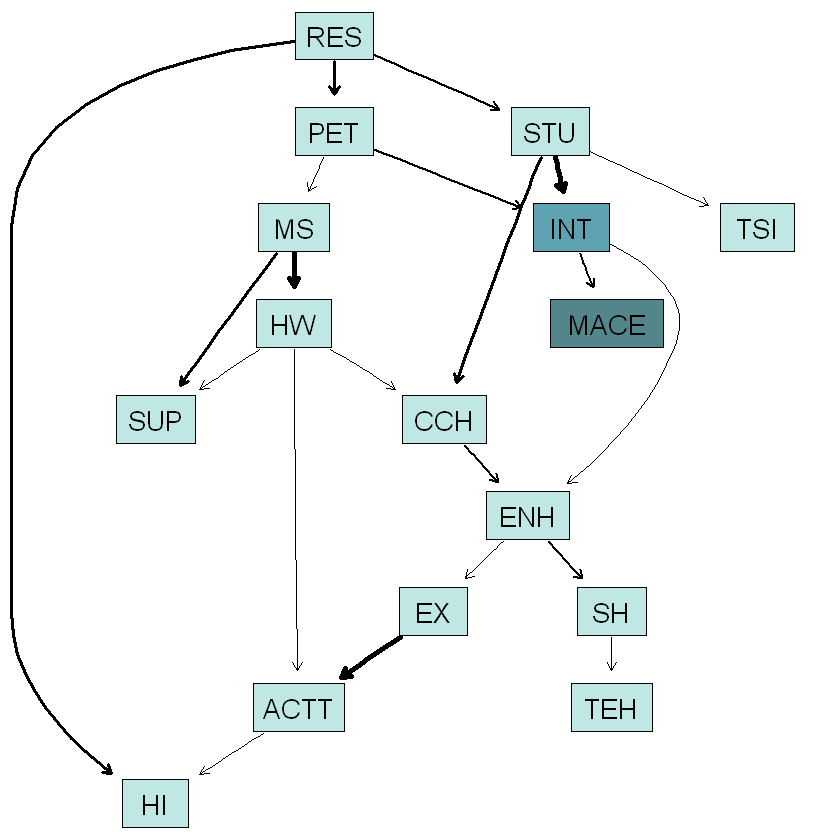

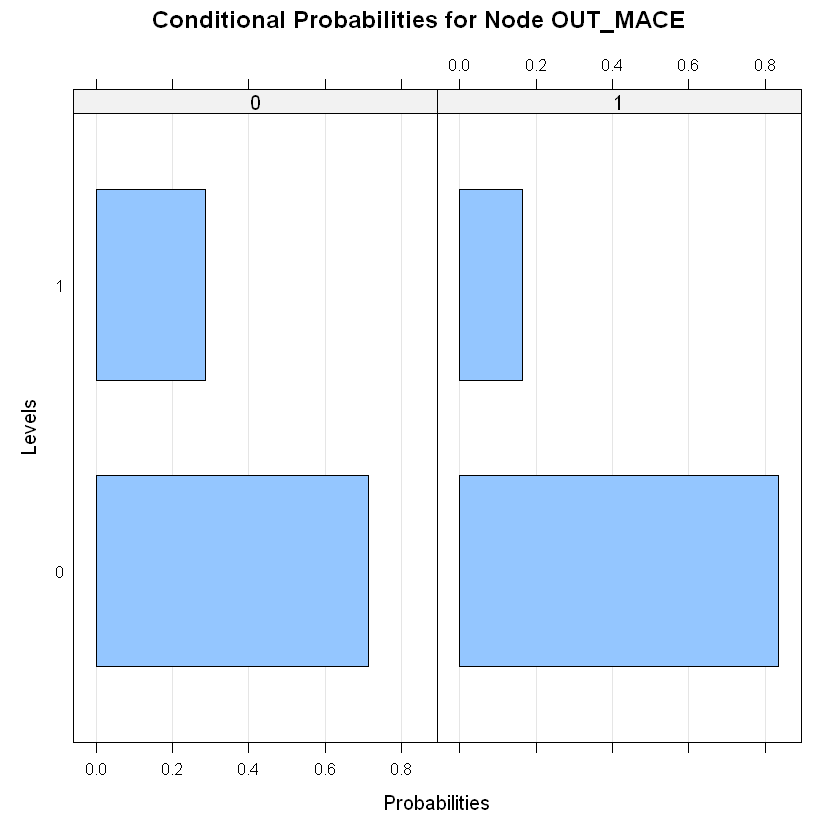

In [84]:
par(bg = "white")
bn_final <- perform_analysis(data, "OUT_MACE", n_iter = 100, threshold = 40, seed = 11)

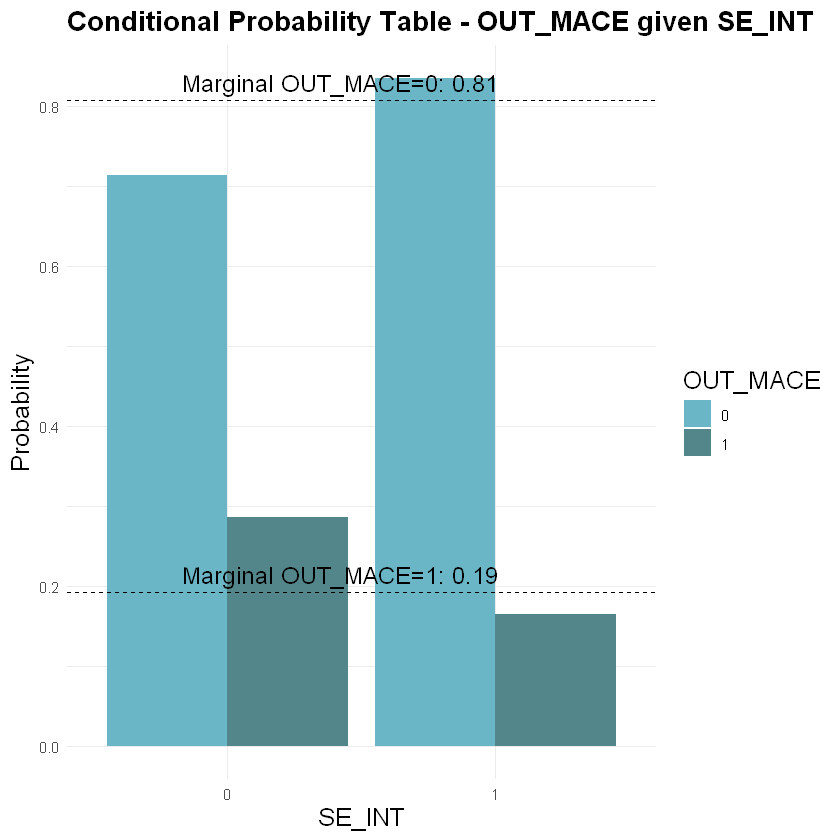

In [85]:
# Plot conditional probabilities of OUT_MACE given each parent variable using bn_final results
cpt <- bn_final$bn_fitted[["OUT_MACE"]]$prob
cpt_dims <- setdiff(names(dimnames(cpt)), "OUT_MACE")
marginal_prob <- prop.table(table(bn_final$final_data[["OUT_MACE"]]))
df_cpt <- as.data.frame.table(cpt)
colnames(df_cpt) <- c(names(dimnames(cpt)), "Freq")
for (mb_var in cpt_dims) {
    gg <- ggplot(df_cpt, aes(x = .data[[mb_var]], y = Freq, fill = .data[["OUT_MACE"]])) +
        geom_bar(stat = "identity", position = "dodge") +
        scale_fill_manual(values = c("0" = "#6ab5c6", "1" = "#53868B")) +
        labs(title = paste("Conditional Probability Table - OUT_MACE given", mb_var),
             x = mb_var, y = "Probability") + 
        theme_minimal() +
        theme(plot.title = element_text(size = 16, face = "bold"), 
              axis.title = element_text(size = 15), legend.title = element_text(size = 15)) +
        geom_hline(yintercept = marginal_prob["1"], linetype = "dashed", color = "black") +
        annotate("text", x = Inf, y = marginal_prob["1"], vjust = -0.5, hjust = 1.5, size = 5,
                 label = sprintf("Marginal OUT_MACE=1: %.2f", marginal_prob["1"])) +
        geom_hline(yintercept = marginal_prob["0"], linetype = "dashed", color = "black") +
        annotate("text", x = Inf, y = marginal_prob["0"], vjust = -0.5, hjust = 1.5, size = 5,
                 label = sprintf("Marginal OUT_MACE=0: %.2f", marginal_prob["0"]))
    print(gg)
}


	Mutual Information (disc.)

data:  SE_HW ~ SE_MS  
mi = 162.88, df = 1, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0



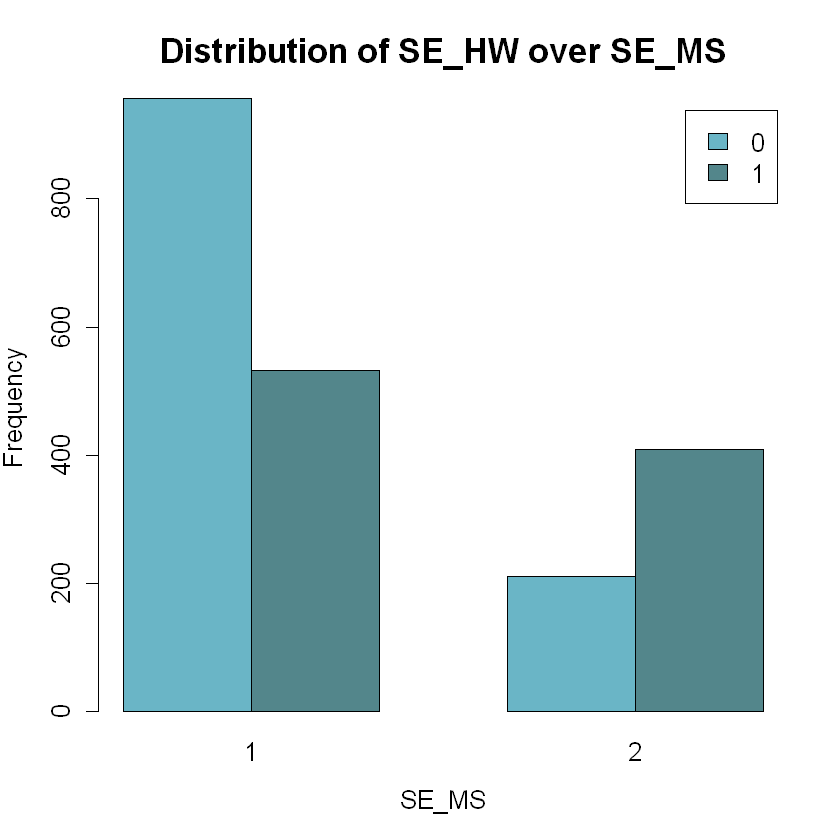

In [137]:
# Function to compare two variables with a barplot and a chi-square test
compare_variables <- function(data, variable1, variable2){
    test_result <- ci.test(variable1, variable2, data = data)
    print(test_result)
    table <- table(data[, variable1], data[, variable2])
    par(bg = "white")
    barplot(
        table, beside = TRUE, legend = TRUE, col = c("#6ab5c6", "#53868B"),
        xlab = variable2, ylab = "Frequency",
        main = paste("Distribution of", variable1, "over", variable2),
        cex.lab = 1.3, cex.main = 1.7, cex.names = 1.3, cex.axis = 1.3, args.legend = list(cex = 1.3)
    )
}

compare_variables(data, "SE_HW", "SE_MS")

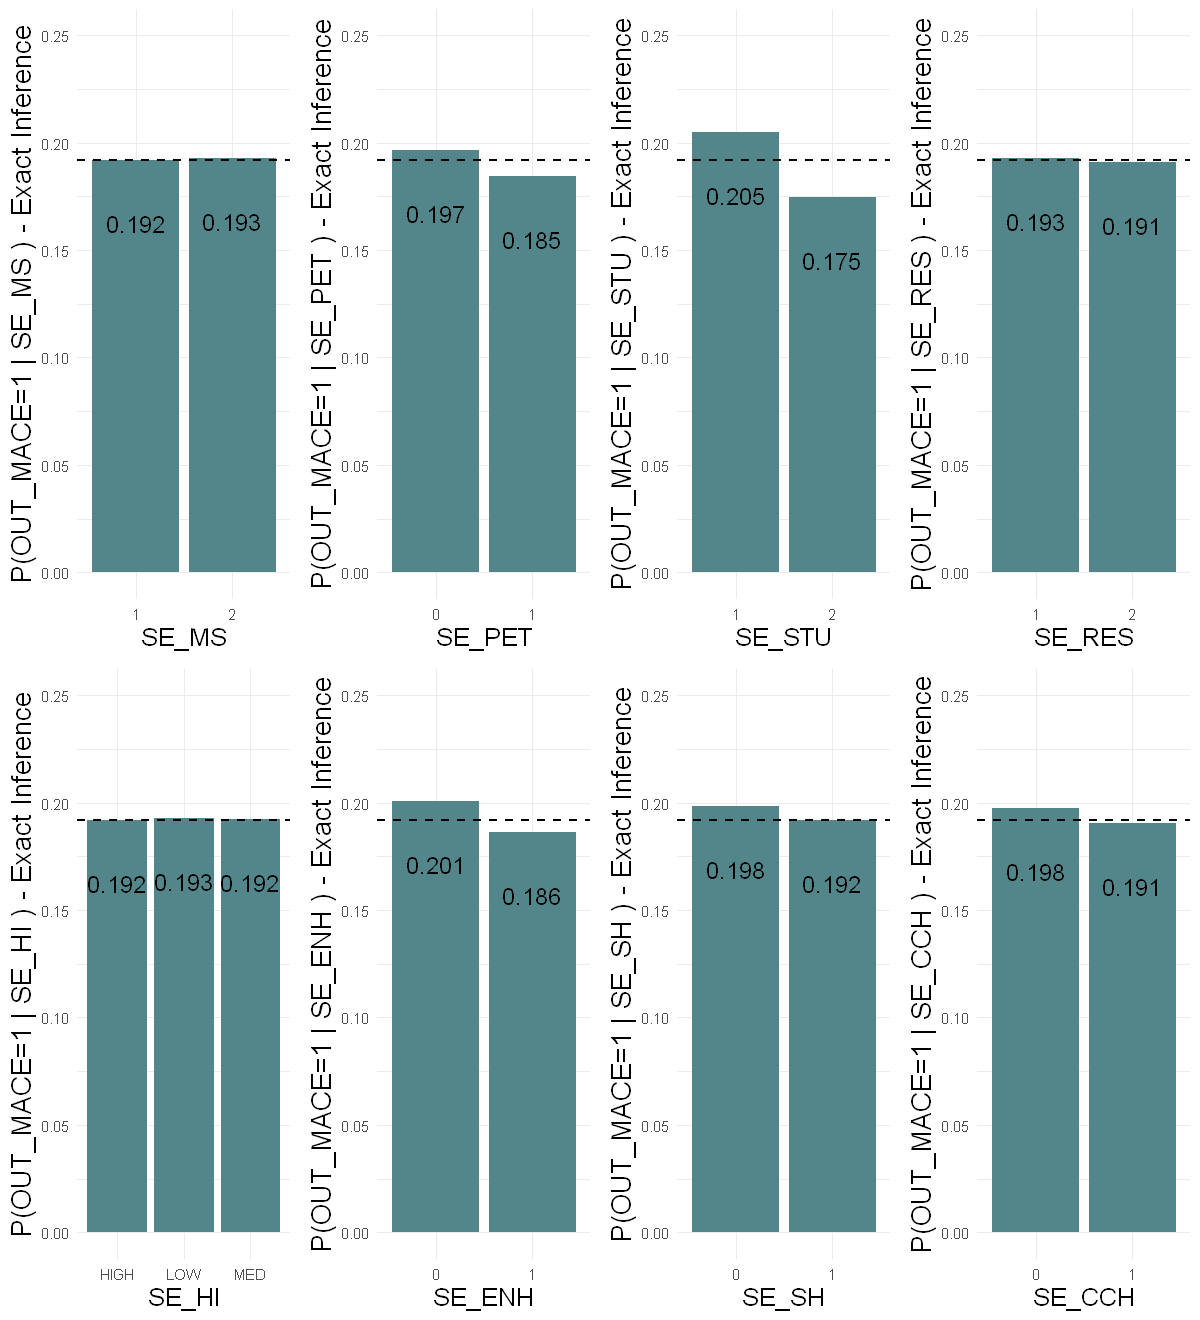

In [132]:
options(repr.plot.width = 10, repr.plot.height = 11)

# Plot exact conditional probabilities of OUT_MACE given SE_MS, SE_PET, SE_STU, SE_RES using querygrain
target_vars <- c("SE_MS", "SE_PET", "SE_STU", "SE_RES", "SE_HI", "SE_ENH", "SE_SH", "SE_CCH")
plots <- list()
for (var in target_vars) {
    levels_var <- levels(bn_final$final_data[[var]])
    probs <- sapply(levels_var, function(lvl) {
        querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = setNames(list(lvl), var))$OUT_MACE["1"]
    })
    df_plot <- data.frame(
        Level = levels_var,
        Probability = as.numeric(probs)
    )
    gg <- ggplot(df_plot, aes(x = Level, y = Probability, fill = Level)) +
        geom_bar(stat = "identity", show.legend = FALSE) +
        geom_text(aes(label = sprintf("%.3f", Probability)), vjust = 4, size = 5) +
        scale_fill_manual(values = rep("#53868B", length(levels_var))) +
        geom_hline(yintercept = marginal_prob["1"], linetype = "dashed", color = "black", linewidth = 0.8) +

        labs(x = var, y = paste("P(OUT_MACE=1 |", var, ") - Exact Inference")) +
        ylim(0, 0.25) +
        theme_minimal() +
        theme(axis.title.y = element_text(size = 16),
              axis.title.x = element_text(size = 15))
    plots[[var]] <- gg
}
grid.arrange(grobs = plots, nrow = 2)
options(repr.plot.width = NULL, repr.plot.height = NULL)

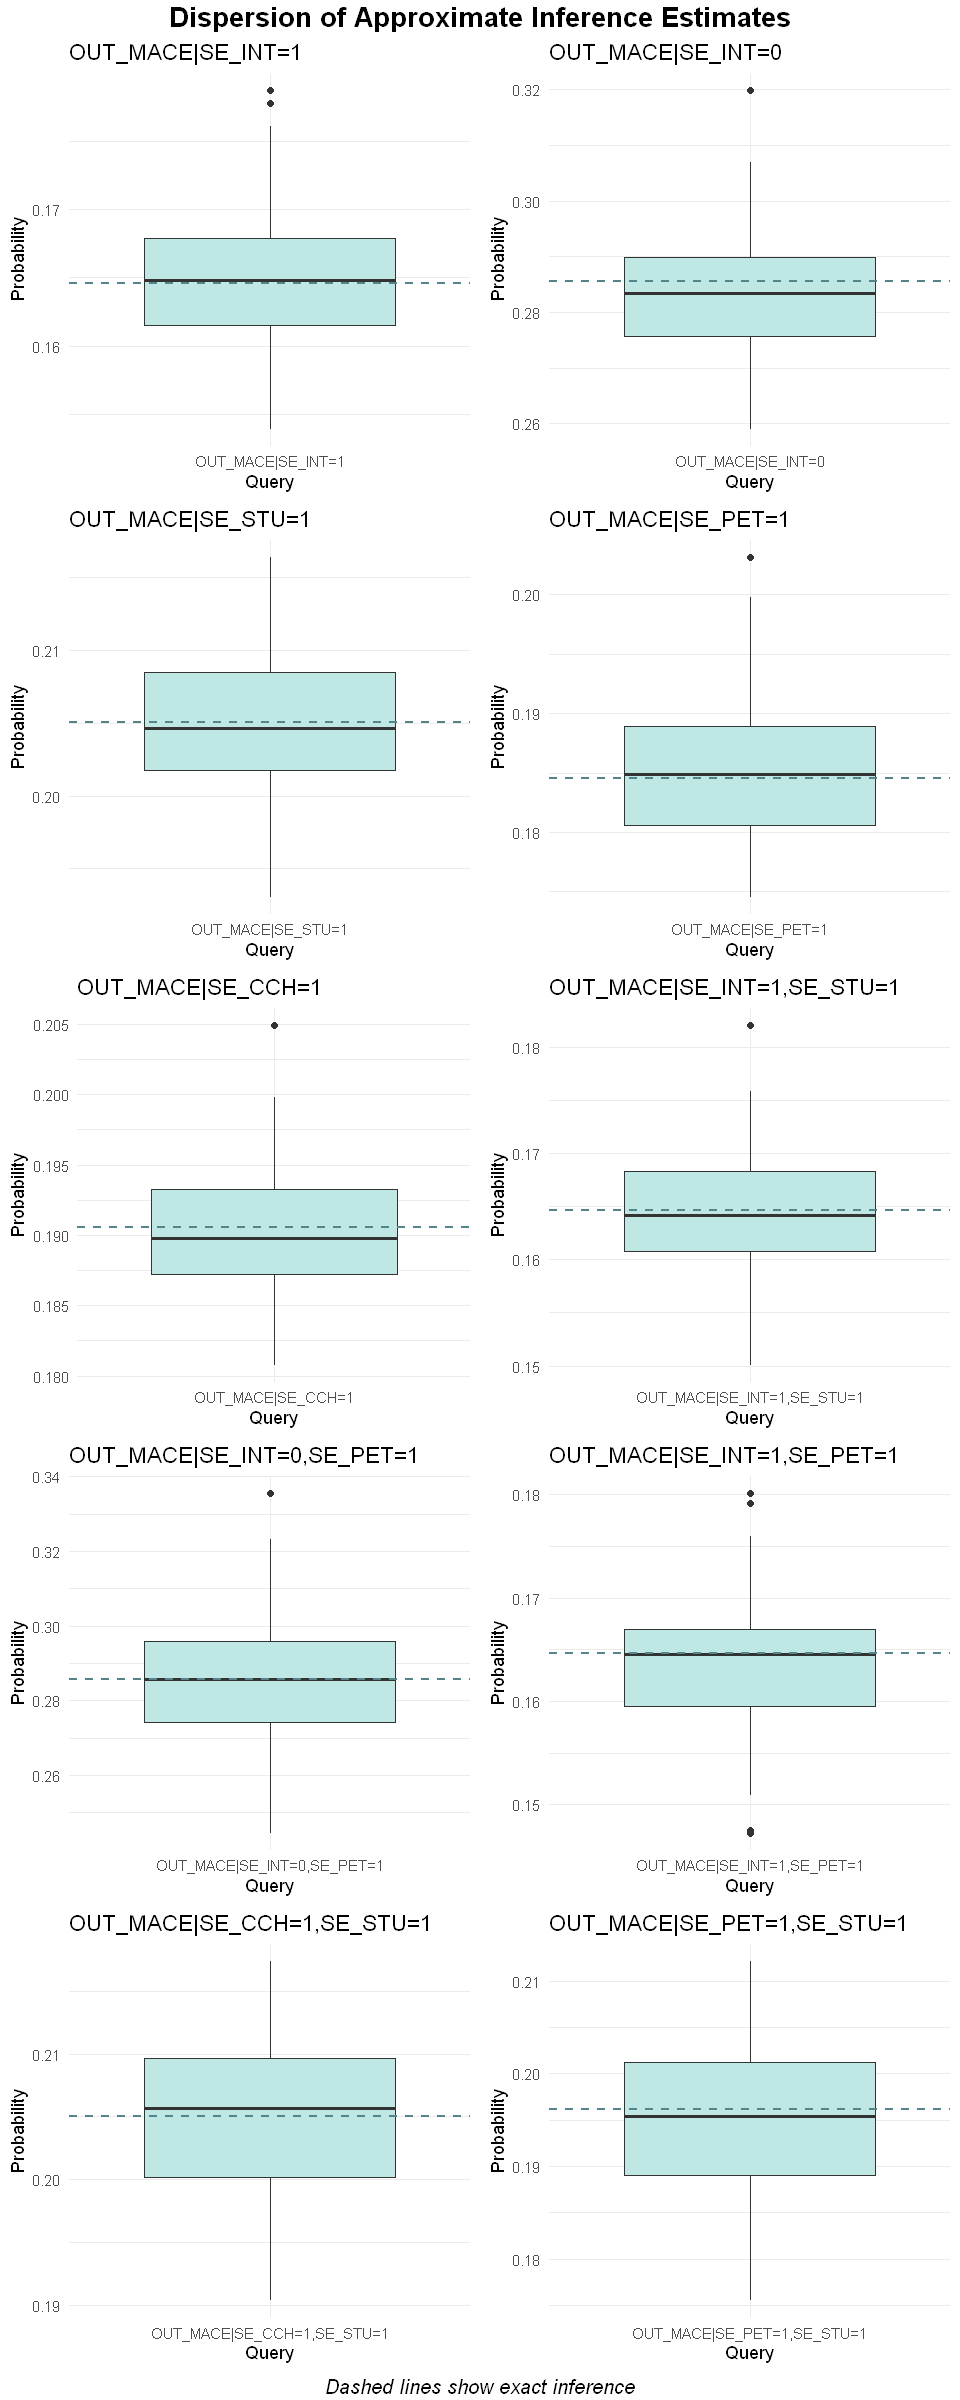

In [ ]:
# Store exact probabilities for each query in a named list
exact_probs <- list(
    "OUT_MACE|SE_INT=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_INT = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=0" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_INT = "0"))$OUT_MACE["1"],
    "OUT_MACE|SE_STU=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_STU = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_PET=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_PET = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_CCH=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_CCH = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=1,SE_STU=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_STU = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=0,SE_PET=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_INT = "0", SE_PET = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_INT=1,SE_PET=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_INT = "1", SE_PET = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_CCH=1,SE_STU=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_CCH = "1", SE_STU = "1"))$OUT_MACE["1"],
    "OUT_MACE|SE_PET=1,SE_STU=1" = querygrain(bn_final$junction, nodes = "OUT_MACE", evidence = list(SE_PET = "1", SE_STU = "1"))$OUT_MACE["1"]
)

# # Print all exact probabilities in a compact way
# cat("Exact conditional probabilities of OUT_MACE = 1:\n")
# print(exact_probs)

# Approximate inference using cpquery
set.seed(0)
approx_outmace_seint1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = (SE_INT == "1")))
approx_outmace_seint0 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = (SE_INT == "0")))
approx_outmace_sestu1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = (SE_STU == "1")))
approx_outmace_sepet1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = (SE_PET == "1")))
approx_outmace_secch1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = (SE_CCH == "1")))
approx_outmace_seint1_sestu1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = ((SE_INT == "1") & (SE_STU == "1"))))
approx_outmace_seint0_sepet1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = ((SE_INT == "0") & (SE_PET == "1"))))
approx_outmace_seint1_sepet1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = ((SE_INT == "1") & (SE_PET == "1"))))
approx_outmace_secch1_sestu1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = ((SE_CCH == "1") & (SE_STU == "1"))))
approx_outmace_sepet1_sestu1 <- replicate(100, cpquery(bn_final$bn_fitted, event = (OUT_MACE == "1"), evidence = ((SE_PET == "1") & (SE_STU == "1"))))

# Combine results into a data frame for visualization
approx_results <- data.frame(
    Variable = rep(c(
        "OUT_MACE|SE_INT=1",
        "OUT_MACE|SE_INT=0",
        "OUT_MACE|SE_STU=1",
        "OUT_MACE|SE_PET=1",
        "OUT_MACE|SE_CCH=1",
        "OUT_MACE|SE_INT=1,SE_STU=1",
        "OUT_MACE|SE_INT=0,SE_PET=1",
        "OUT_MACE|SE_INT=1,SE_PET=1",
        "OUT_MACE|SE_CCH=1,SE_STU=1",
        "OUT_MACE|SE_PET=1,SE_STU=1"
    ), each = 100),
    Probability = c(
        approx_outmace_seint1,
        approx_outmace_seint0,
        approx_outmace_sestu1,
        approx_outmace_sepet1,
        approx_outmace_secch1,
        approx_outmace_seint1_sestu1,
        approx_outmace_seint0_sepet1,
        approx_outmace_seint1_sepet1,
        approx_outmace_secch1_sestu1,
        approx_outmace_sepet1_sestu1
    )
)

options(repr.plot.width = 8, repr.plot.height = 20)

# Create boxplots for each query, add exact inference line
plots <- lapply(unique(approx_results$Variable), function(var) {
    ggplot(subset(approx_results, Variable == var), aes(x = Variable, y = Probability)) +
        geom_boxplot(fill = "#BFE8E4") +
        geom_hline(yintercept = exact_probs[[var]], linetype = "dashed", color = "#53868B", lwd = 0.75) +
        labs(x = "Query", y = "Probability", title = var) +
        theme_minimal()
})

# Arrange plots in a grid with bold and centered title
grid.arrange(
    grobs = plots,
    ncol = 2,
    top = textGrob("Dispersion of Approximate Inference Estimates", gp = gpar(fontsize = 16, fontface = "bold"), just = "center", hjust = 0.5),
    bottom = textGrob("Dashed lines show exact inference", gp = gpar(fontsize = 12, fontface = "italic"))
)
options(repr.plot.width = NULL, repr.plot.height = NULL)

## Bayesian Networks per Cluster

In [90]:
# Load the dataset
dfC <- read.csv('FINAL_DATASET_CLUSTERED.csv')

# Select the socioeconomic variables, the outcome variable and the and convert them to factors
dataC <- dfC %>% select(c(starts_with("SE_"), OUT_MACE, cluster_kmodes)) %>% mutate(across(everything(), as.factor))

data1 <- dataC %>% filter(cluster_kmodes == "1") %>% select(-c(cluster_kmodes))
data2 <- dataC %>% filter(cluster_kmodes == "2") %>% select(-c(cluster_kmodes))
data3 <- dataC %>% filter(cluster_kmodes == "3") %>% select(-c(cluster_kmodes))
dataA <- dataC %>% filter(cluster_kmodes %in% c("1", "2")) %>% select(-c(cluster_kmodes))

BIC score of the DAG learned with hill-climbing (Cluster 1 and 2): -13141.21 
BIC score of the DAG learned with hill-climbing (Cluster 3): -3839.616 


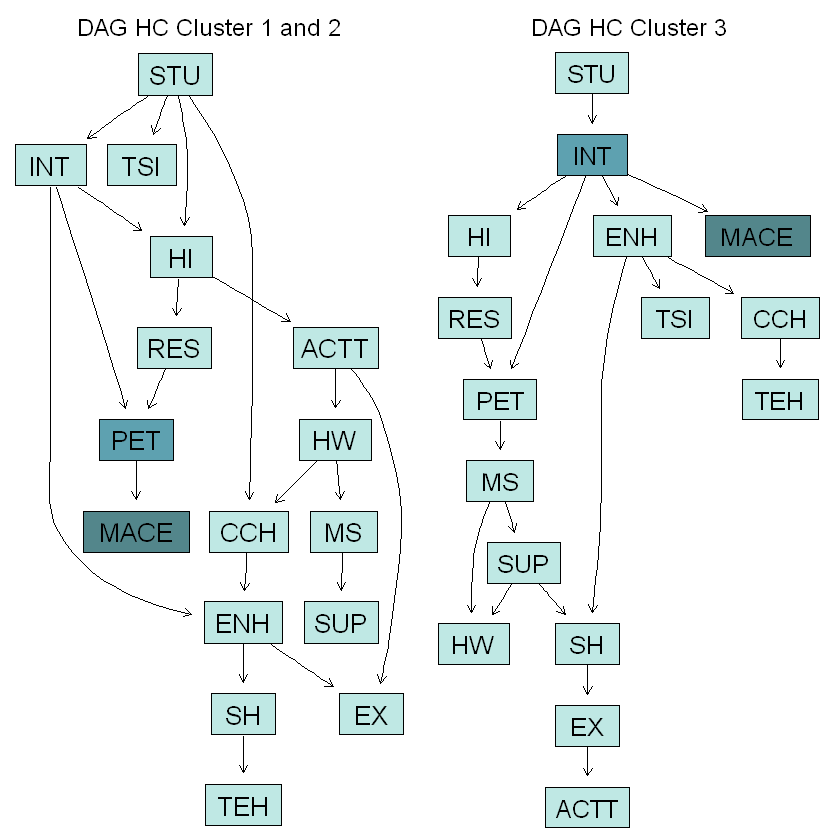

In [91]:
# Learn the DAG using the hill-climbing algorithm for each cluster
dag_hc1 <- hc(dataA, score = "bic")
score_hc1 <- score(dag_hc1, data = dataA, type = "bic")

# dag_hc2 <- hc(data2, score = "bic")
# score_hc2 <- score(dag_hc2, data = data2, type = "bic")

dag_hc3 <- hc(data3, score = "bic")
score_hc3 <- score(dag_hc3, data = data3, type = "bic")

cat("BIC score of the DAG learned with hill-climbing (Cluster 1 and 2):", score_hc1, "\n")
# cat("BIC score of the DAG learned with hill-climbing (Cluster 2):", score_hc2, "\n")
cat("BIC score of the DAG learned with hill-climbing (Cluster 3):", score_hc3, "\n")

# Plot the three DAGs for comparison
mb_hc1 <- mb(dag_hc1, "OUT_MACE")
# mb_hc2 <- mb(dag_hc2, "OUT_MACE")
mb_hc3 <- mb(dag_hc3, "OUT_MACE")

get_node_colors <- function(dag, mb_nodes) {
    colors <- rep("#BFE8E4", length(nodes(dag)))
    names(colors) <- nodes(dag)
    colors["OUT_MACE"] <- "#53868B"
    colors[mb_nodes] <- "#5EA1B0"
    return(colors)
}

remove_prefix <- function(x) sub("^(SE_|OUT_)", "", x)

node_colors_hc1 <- get_node_colors(dag_hc1, mb_hc1)
# node_colors_hc2 <- get_node_colors(dag_hc2, mb_hc2)
node_colors_hc3 <- get_node_colors(dag_hc3, mb_hc3)

labels_hc1 <- setNames(remove_prefix(nodes(dag_hc1)), nodes(dag_hc1))
# labels_hc2 <- setNames(remove_prefix(nodes(dag_hc2)), nodes(dag_hc2))
labels_hc3 <- setNames(remove_prefix(nodes(dag_hc3)), nodes(dag_hc3))

par(mfrow = c(1, 2), bg = "white")
g_hc1 <- graphviz.plot(dag_hc1, main = "DAG HC Cluster 1 and 2", render = FALSE)
graph::nodeRenderInfo(g_hc1)$fill <- node_colors_hc1
graph::nodeRenderInfo(g_hc1)$label <- labels_hc1
Rgraphviz::renderGraph(g_hc1)

# g_hc2 <- graphviz.plot(dag_hc2, main = "DAG HC Cluster 2", render = FALSE)
# graph::nodeRenderInfo(g_hc2)$fill <- node_colors_hc2
# graph::nodeRenderInfo(g_hc2)$label <- labels_hc2
# Rgraphviz::renderGraph(g_hc2)

g_hc3 <- graphviz.plot(dag_hc3, main = "DAG HC Cluster 3", render = FALSE)
graph::nodeRenderInfo(g_hc3)$fill <- node_colors_hc3
graph::nodeRenderInfo(g_hc3)$label <- labels_hc3
Rgraphviz::renderGraph(g_hc3)

Frecuency of arcs in the bootstrap samples:
        from       to Freq
1      SE_HI   SE_INT   99
2      SE_MS   SE_SUP   99
3     SE_STU    SE_HI   99
4      SE_HW   SE_CCH   96
5      SE_MS    SE_HW   88
6      SE_HI   SE_RES   87
7      SE_SH   SE_TEH   87
8     SE_CCH   SE_ENH   69
9     SE_INT   SE_PET   69
10     SE_EX  SE_ACTT   52
11     SE_HW  SE_ACTT   49
12    SE_CCH   SE_STU   47
13     SE_EX   SE_TEH   47
14    SE_RES   SE_PET   47
15   SE_ACTT    SE_EX   46
16    SE_PET OUT_MACE   37
17    SE_SUP    SE_HW   37
18   SE_ACTT   SE_TSI   33
19    SE_INT   SE_ENH   31
20    SE_INT OUT_MACE   28
21    SE_INT  SE_ACTT   25
22    SE_STU   SE_ENH   25
23   SE_ACTT   SE_PET   24
24    SE_ENH   SE_TSI   23
25    SE_RES  SE_ACTT   23
26    SE_PET   SE_TSI   22
27    SE_STU   SE_CCH   21
28     SE_HW OUT_MACE   19
29    SE_RES   SE_TSI   18
30    SE_TSI    SE_SH   17
31   SE_ACTT    SE_HW   16
32    SE_CCH    SE_EX   16
33    SE_CCH    SE_SH   16
34    SE_SUP   SE_STU   15
35    SE_EN

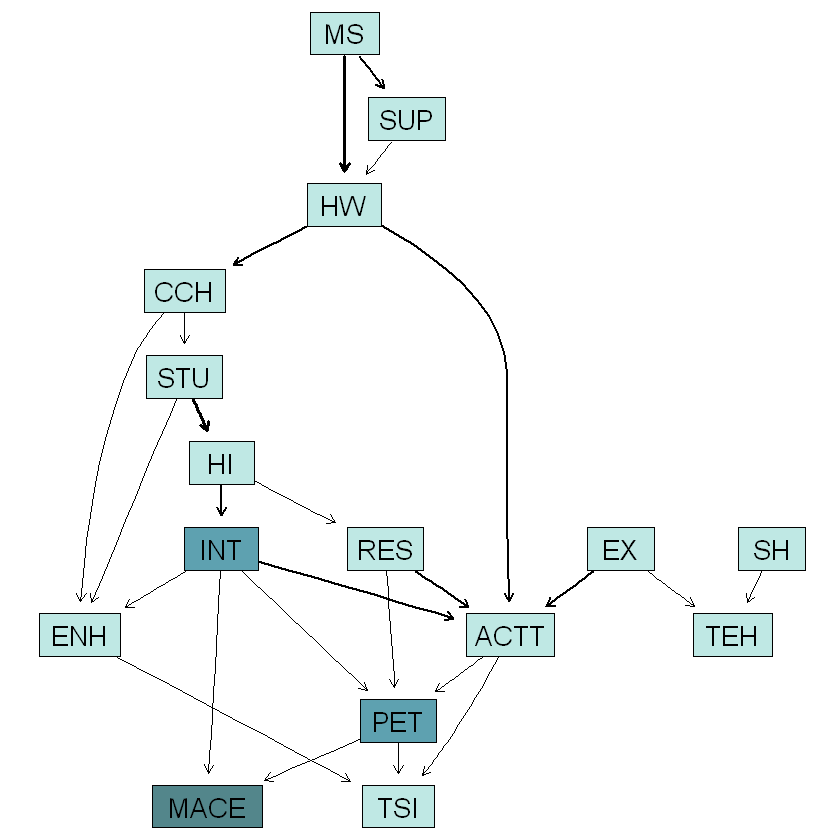

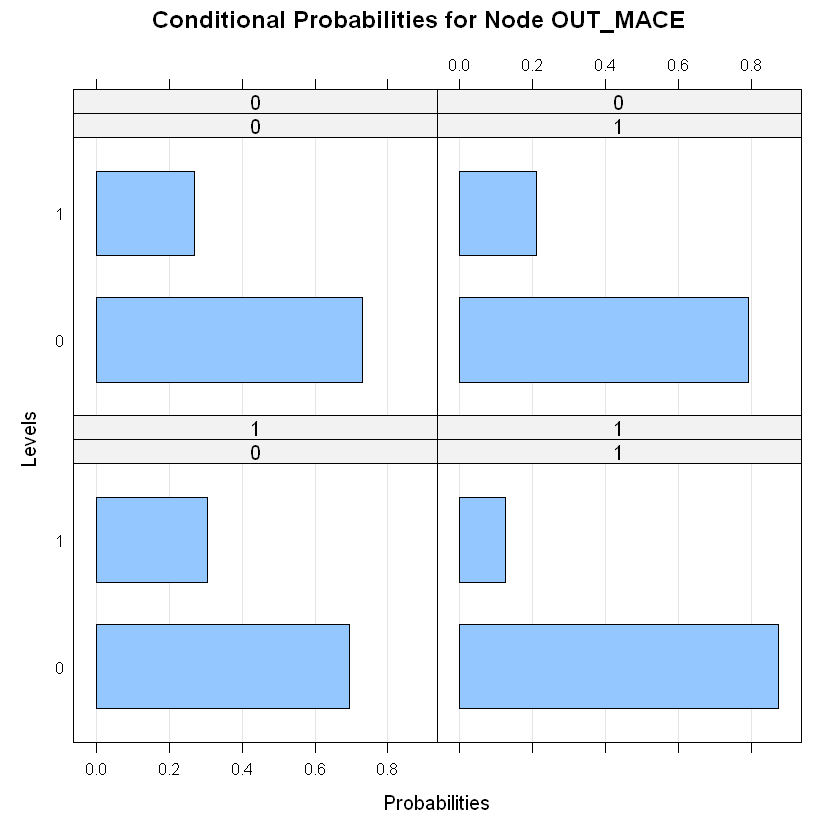

In [92]:
par(bg = "white")
bn_c1 <- perform_analysis(data1, "OUT_MACE", n_iter = 100, threshold = 20, seed = 1)

Frecuency of arcs in the bootstrap samples:
        from       to Freq
1      SE_MS   SE_SUP   99
2     SE_RES   SE_PET   98
3     SE_STU    SE_HI   97
4      SE_EX  SE_ACTT   92
5      SE_HI   SE_RES   83
6      SE_MS    SE_HW   82
7     SE_ENH    SE_SH   66
8     SE_ENH    SE_HW   47
9     SE_ENH    SE_EX   45
10     SE_MS   SE_PET   45
11     SE_EX   SE_ENH   43
12    SE_PET   SE_INT   43
13    SE_ENH   SE_CCH   39
14  OUT_MACE   SE_RES   37
15    SE_STU   SE_INT   36
16     SE_HW   SE_CCH   33
17    SE_INT OUT_MACE   33
18     SE_SH   SE_ENH   33
19    SE_STU   SE_TEH   31
20    SE_ENH   SE_INT   30
21    SE_STU   SE_CCH   26
22    SE_CCH   SE_STU   24
23    SE_INT   SE_STU   23
24    SE_RES   SE_SUP   22
25     SE_MS    SE_EX   21
26    SE_RES   SE_CCH   21
27     SE_HW  SE_ACTT   20
28    SE_RES    SE_EX   19
29     SE_HW    SE_MS   18
30     SE_MS   SE_TSI   18
31    SE_PET    SE_MS   16
32    SE_SUP    SE_EX   16
33    SE_INT   SE_PET   15
34     SE_SH   SE_TEH   15
35    SE_SU

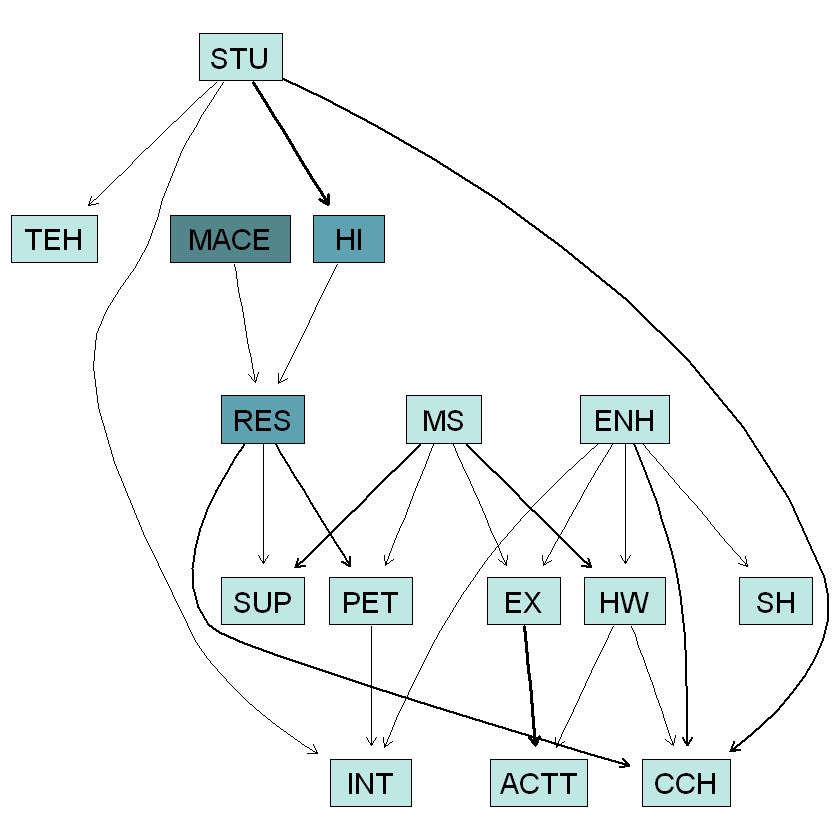

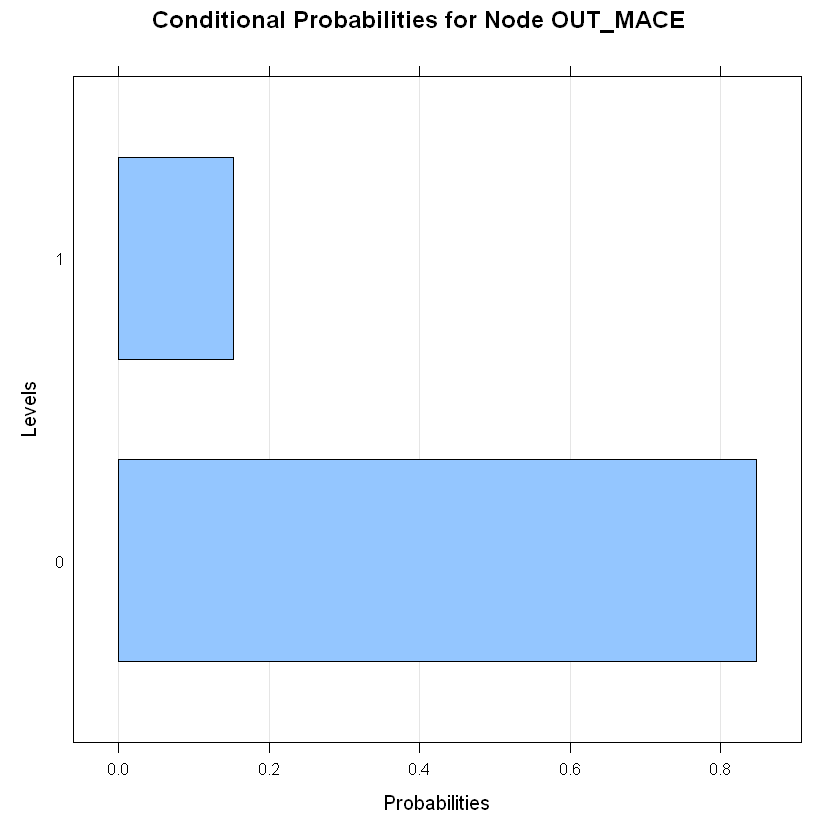

In [93]:
par(bg = "white")
bn_c2 <- perform_analysis(data2, "OUT_MACE", n_iter = 100, threshold = 20, seed = 1)

Frecuency of arcs in the bootstrap samples:
        from       to Freq
1      SE_MS   SE_SUP  100
2      SE_HW   SE_CCH   91
3      SE_SH   SE_TEH   82
4     SE_STU   SE_INT   81
5      SE_HI   SE_RES   79
6      SE_MS    SE_HW   79
7     SE_STU   SE_CCH   78
8     SE_RES   SE_PET   77
9     SE_CCH   SE_ENH   75
10    SE_ENH    SE_SH   70
11    SE_INT   SE_PET   60
12    SE_STU    SE_HI   57
13    SE_INT    SE_HI   56
14     SE_EX  SE_ACTT   52
15   SE_ACTT    SE_EX   48
16     SE_HI  SE_ACTT   47
17     SE_HI   SE_INT   44
18    SE_PET OUT_MACE   44
19     SE_HI   SE_STU   43
20    SE_INT   SE_ENH   40
21   SE_ACTT    SE_HW   38
22    SE_STU   SE_TSI   36
23    SE_STU   SE_TEH   35
24   SE_ACTT    SE_HI   34
25    SE_ENH    SE_EX   34
26   SE_ACTT   SE_PET   32
27     SE_HW  SE_ACTT   30
28    SE_CCH    SE_SH   29
29    SE_STU   SE_ENH   29
30     SE_MS    SE_EX   28
31    SE_RES   SE_SUP   27
32     SE_EX   SE_ENH   24
33     SE_MS   SE_TSI   22
34    SE_PET    SE_MS   22
35    SE_PE

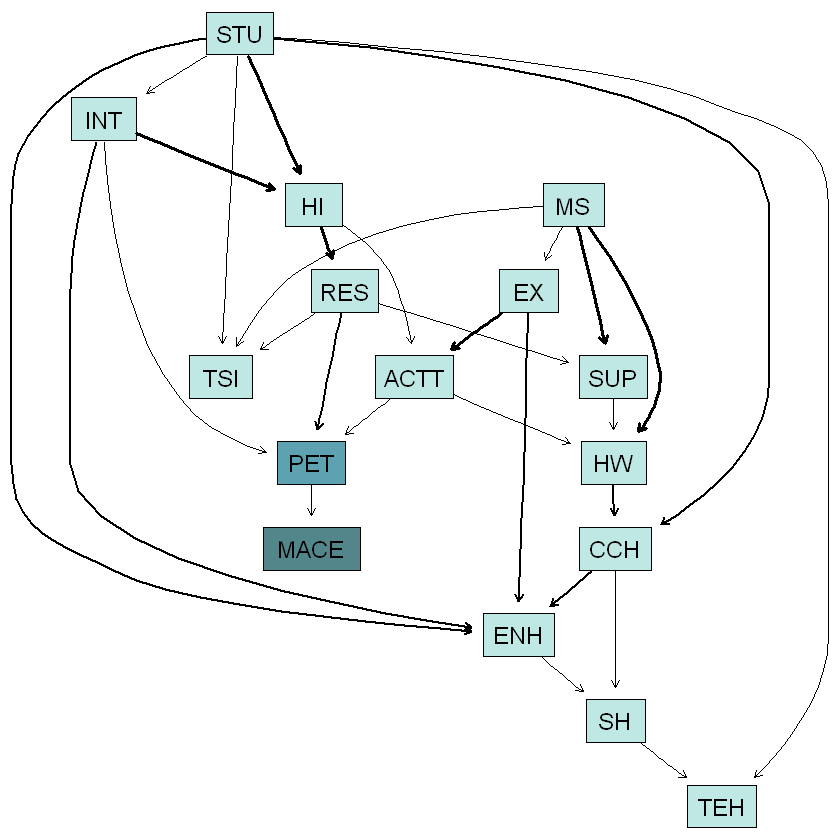

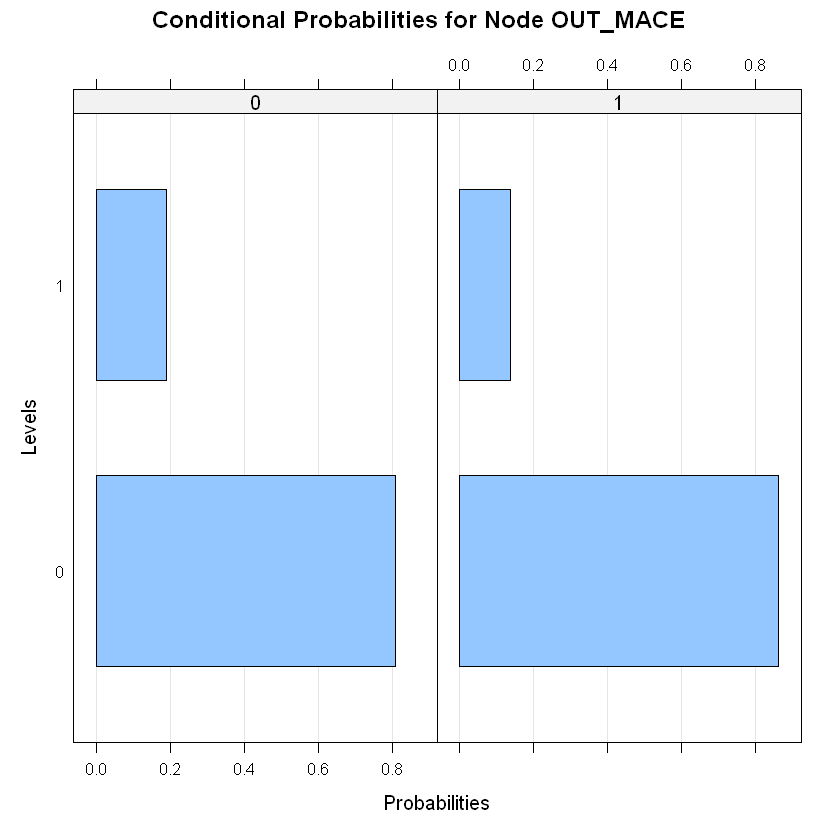

In [94]:
par(bg = "white")
bn_c2 <- perform_analysis(dataA, "OUT_MACE", n_iter = 100, threshold = 20, seed = 1)

Frecuency of arcs in the bootstrap samples:
        from       to Freq
1     SE_INT    SE_HI   99
2      SE_MS   SE_SUP   97
3      SE_MS    SE_HW   95
4      SE_EX  SE_ACTT   90
5     SE_SUP    SE_SH   86
6      SE_HI   SE_RES   80
7     SE_INT OUT_MACE   76
8     SE_RES   SE_PET   71
9     SE_STU   SE_INT   61
10    SE_SUP    SE_HW   56
11    SE_ENH    SE_SH   52
12    SE_CCH   SE_ENH   44
13    SE_PET    SE_MS   40
14     SE_HW  SE_ACTT   39
15    SE_INT   SE_STU   37
16    SE_ENH    SE_EX   36
17     SE_SH    SE_EX   35
18    SE_INT   SE_ENH   34
19    SE_INT   SE_PET   33
20    SE_RES   SE_STU   33
21    SE_ENH   SE_CCH   31
22    SE_ENH   SE_TSI   29
23     SE_MS   SE_PET   27
24     SE_EX   SE_TEH   26
25    SE_TEH   SE_CCH   24
26     SE_SH   SE_TEH   23
27    SE_PET   SE_INT   21
28    SE_CCH   SE_TEH   19
29    SE_CCH   SE_TSI   19
30     SE_HW    SE_EX   19
31     SE_SH   SE_ENH   19
32    SE_STU   SE_RES   19
33     SE_HI   SE_ENH   17
34     SE_EX    SE_SH   16
35    SE_RE

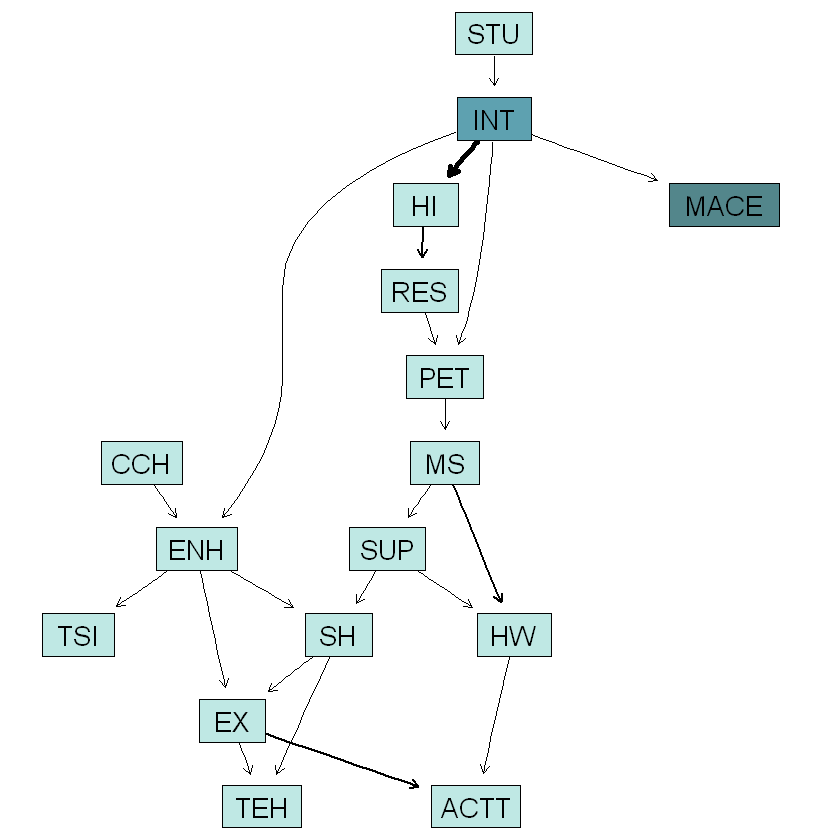

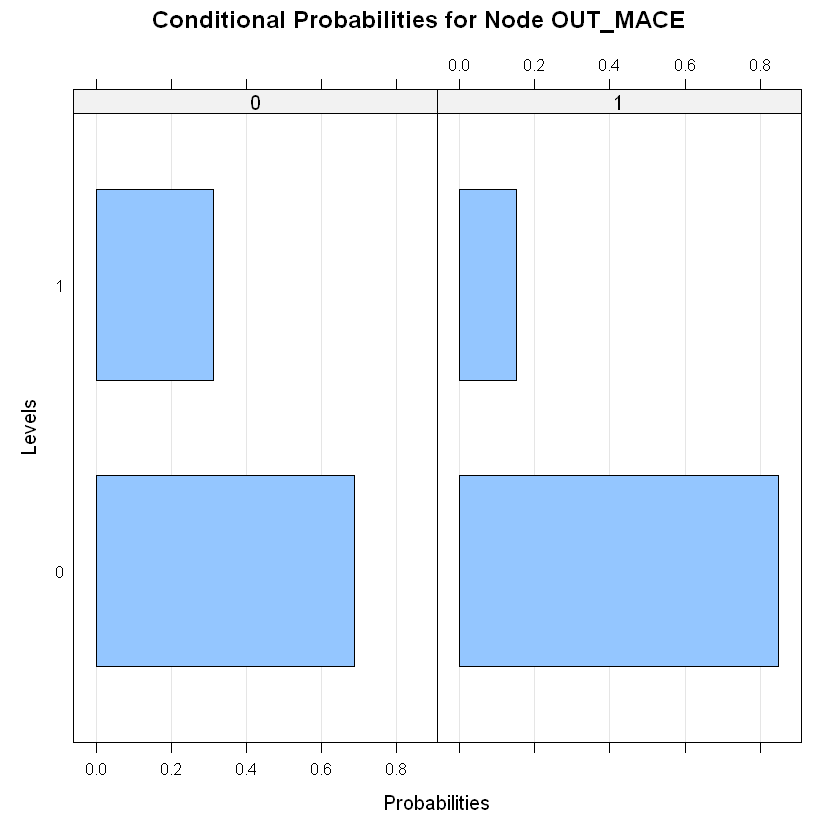

In [95]:
par(bg = "white")
bn_c3 <- perform_analysis(data3, "OUT_MACE", n_iter = 100, threshold = 20, seed = 1)